In [1]:
import os
import time

# spark imports
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# spark config
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.master", "local[4]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext

In [164]:
genres = pd.read_csv("./ml-100k/u.item",sep="|",names = ["item_id", "movie_title",\
            "release date", "video release date", "IMDb URL", "unknown", "Action",\
            "Adventure","Animation", "Children's", "Comedy", "Crime", "Documentary",\
            "Drama","Fantasy", "Film-Noir", "Horror", "Musical", "Mystery",\
            "Romance","Sci-Fi", "Thriller", "War", "Western"], encoding='latin-1')

ratings = pd.read_csv("./ml-100k/u1.base",sep="\t",names = ["user_id", "item_id" , "ratings", "timestamp"])
users=pd.read_csv("./ml-100k/u.user",sep='|',names=['user_id', 'age', 'sex', 'occupation', 'zip_code'])



MovieG = list(genres.columns.values)[-19:]
movgen=[]
genres1 = np.array(genres)
for i in range(len(genres)):
    gen = []
    for j in range(6,24):
        if genres1[i][j] == 1:
            gen.append(MovieG[j - 5])
    movgen.append([i+1,gen])

for i in range(len(movgen)):
    movgen[i][1] = '|'.join(str(x) for x in movgen[i][1])
    
movgenDF = pd.DataFrame(movgen, columns=["item_id","genres"])    
final_genres = pd.merge(genres, movgenDF, on = "item_id")
final_genres = final_genres[["item_id","movie_title","genres"]]
final_genres["Year"] = final_genres["movie_title"].str.split(" ").apply(lambda x: x[-1].lstrip('(').rstrip(')'))
final_genres["movie_title"] = final_genres["movie_title"].str.split(" ").apply(lambda x: ' '.join(str(x) for x in x[:-1]))
movies = final_genres[["item_id", "movie_title", "genres"]]


In [165]:
movies = spark.createDataFrame(movies)
ratings = spark.createDataFrame(ratings)

In [166]:
movies.show(5)

+-------+-----------+--------------------+
|item_id|movie_title|              genres|
+-------+-----------+--------------------+
|      1|  Toy Story|Animation|Childre...|
|      2|  GoldenEye|Action|Adventure|...|
|      3| Four Rooms|            Thriller|
|      4| Get Shorty| Action|Comedy|Drama|
|      5|    Copycat|Crime|Drama|Thriller|
+-------+-----------+--------------------+
only showing top 5 rows



In [167]:
ratings.show(5)

+-------+-------+-------+---------+
|user_id|item_id|ratings|timestamp|
+-------+-------+-------+---------+
|      1|      1|      5|874965758|
|      1|      2|      3|876893171|
|      1|      3|      4|878542960|
|      1|      4|      3|876893119|
|      1|      5|      3|889751712|
+-------+-------+-------+---------+
only showing top 5 rows



In [162]:
print('Distinct value of ratings')
print(sorted(ratings.select('ratings').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct value of ratings
[1, 2, 3, 4, 5]


In [137]:
ratings.columns

['user_id', 'item_id', 'ratings', 'timestamp']

In [168]:
minimum_ratings_user = ratings.groupBy('user_id').count().toPandas()['count'].min()
minimum_ratings_movie = ratings.groupBy('item_id').count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(minimum_ratings_user))
print('Minimum number of ratings per movie is {}'.format(minimum_ratings_movie))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 4
Minimum number of ratings per movie is 1


In [169]:
one_rated_movie = sum(ratings.groupBy('item_id').count().toPandas()['count'] == 1)
total_movies =ratings.select('item_id').distinct().count()
print('{} out of {} movies are rated by only one user'.format(one_rated_movie, total_movies))

141 out of 1650 movies are rated by only one user


In [170]:
total_users = ratings.select('user_id').distinct().count()
print('We have a total of {} distinct users in the data sets'.format(total_users))

We have a total of 943 distinct users in the data sets


In [171]:
total_movies = movies.select('item_id').distinct().count()
print('We have a total of {} distinct movies in the data sets'.format(total_movies))

We have a total of 1683 distinct movies in the data sets


In [172]:
movies_rated = ratings.select('item_id').distinct().count()
print('We have a total of {} distinct movies that are rated by users in ratings table'.format(movies_rated))
print('We have {} movies that are not rated yet'.format(total_movies-movies_rated))

We have a total of 1650 distinct movies that are rated by users in ratings table
We have 33 movies that are not rated yet


In [175]:
movies.createOrReplaceTempView("movies") 
ratings.createOrReplaceTempView("ratings") 
print('List movies that are not rated yet: ')

spark.sql("SELECT item_id, movie_title from movies where item_id not in (select distinct(item_id) from ratings)").show(10)



List movies that are not rated yet: 
+-------+--------------------+
|item_id|         movie_title|
+-------+--------------------+
|    599|Police Story 4: P...|
|    711|Substance of Fire...|
|    814|Great Day in Harl...|
|    830|            Power 98|
|    852|   Bloody Child, The|
|    857|   Paris Was a Woman|
|   1156|               Cyclo|
|   1236|Other Voices, Oth...|
|   1309|Very Natural Thin...|
|   1310|  Walk in the Sun, A|
+-------+--------------------+
only showing top 10 rows



In [176]:
# define a udf for splitting the genres string
splitter = UserDefinedFunction(lambda x: x.split('|'), ArrayType(StringType()))
# query
print('All distinct genres: ')
movies.select(explode(splitter("genres")).alias("genres")).distinct().show()

All distinct genres: 
+-----------+
|     genres|
+-----------+
|      Crime|
|    Romance|
|   Thriller|
|  Adventure|
| Children's|
|      Drama|
|        War|
|Documentary|
|    Fantasy|
|    Mystery|
|    Musical|
|  Animation|
|  Film-Noir|
|     Horror|
|    Western|
|           |
|     Comedy|
|     Action|
|     Sci-Fi|
+-----------+



In [178]:
movies.select('item_id', explode(splitter("genres")).alias("genres")) \
    .groupby('genres') \
    .count() \
    .sort(desc('count')) \
    .show()

+-----------+-----+
|     genres|count|
+-----------+-----+
|      Drama|  726|
|     Comedy|  505|
|   Thriller|  252|
|     Action|  252|
|    Romance|  247|
|  Adventure|  135|
| Children's|  122|
|      Crime|  109|
|     Sci-Fi|  102|
|     Horror|   92|
|        War|   71|
|    Mystery|   61|
|    Musical|   56|
|Documentary|   50|
|  Animation|   42|
|    Western|   27|
|  Film-Noir|   24|
|    Fantasy|   22|
|           |    2|
+-----------+-----+



In [179]:
#loading data 
movie_rating = sc.textFile("./ml-100k/u.data")


In [180]:
#preprocessing data
rating_data = movie_rating \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split("\t")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()


#splitting
train,validation,test = rating_data.randomSplit([6,2,2], seed = 0)
train.cache()
validation.cache()
test.cache()

PythonRDD[22203] at RDD at PythonRDD.scala:52

In [181]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    RankList = []
    RegParamList = []
    errorList = []
    for rank in ranks:
        for reg in reg_param:
            model = ALS.train(ratings = train_data, iterations = num_iters, rank = rank, lambda_ = reg, seed = 0)
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            #get RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            RankList.append(rank)
            RegParamList.append(reg)
            errorList.append(error)
            
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model,RankList,RegParamList,errorList

In [182]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 1.3369472336001607
8 latent factors and regularization = 0.01: validation RMSE is 1.1157307624388038
8 latent factors and regularization = 0.05: validation RMSE is 0.988979955489546
8 latent factors and regularization = 0.1: validation RMSE is 0.9444843607210194
8 latent factors and regularization = 0.2: validation RMSE is 0.9455376191359919
10 latent factors and regularization = 0.001: validation RMSE is 1.4283407981685312
10 latent factors and regularization = 0.01: validation RMSE is 1.1715788026976255
10 latent factors and regularization = 0.05: validation RMSE is 1.0062485941402246
10 latent factors and regularization = 0.1: validation RMSE is 0.9489511245138381
10 latent factors and regularization = 0.2: validation RMSE is 0.947043958396967
12 latent factors and regularization = 0.001: validation RMSE is 1.5284832111277524
12 latent factors and regularization = 0.01: validation RMSE is 1.200066626110853
12 latent fac

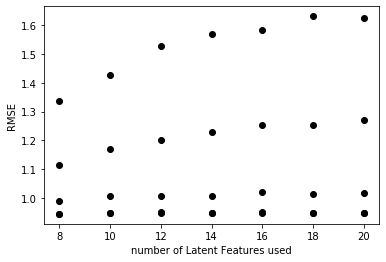

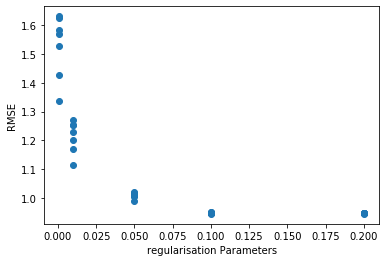

In [227]:
import seaborn as sns
plt.plot(RankList, errorList, marker='o', c='black', linestyle = 'None')
plt.xlabel('number of Latent Features used')
plt.ylabel('RMSE')
plt.show()


plt.xlabel('regularisation Parameters')
plt.ylabel('RMSE')
plt.plot(RegParamList, errorList, marker='o',  linestyle = 'None')
plt.show()




In [187]:
def plotting(arr_iters, train_data, validation_data, reg, rank):
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=0)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

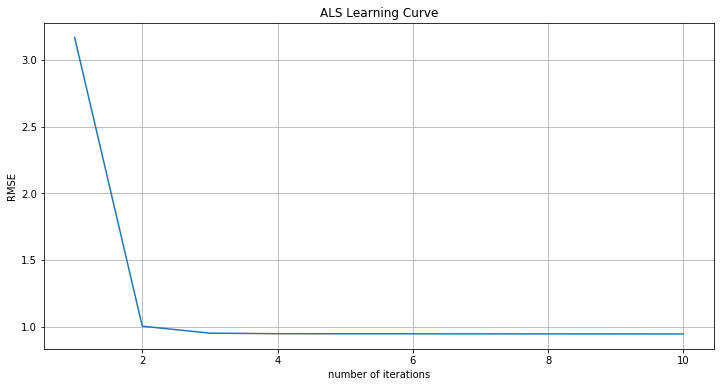

In [188]:

# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plotting(iter_array, train, validation, 0.1, 8)

In [196]:
def movie_recommendations(user_input_movie, iterations, latent, lambdaF, ratings, movies, recommendations, sparkC):
        #get movie list of user input first
        movieIdList = []
        for movie in user_input_movie:
            movieID = movies.filter(movies.movie_title.like('%{}%'.format(movie)))\
                                 .select('item_id')\
                                 .rdd\
                                 .map(lambda r: r[0])\
                                 .collect()
            movieIdList.extend(movieID)
        movieIdList = list(set(movieIdList))
        
        #next adding new users to the list
        new_user = ratings.map(lambda r: r[0]).max() + 1
        max_rating = ratings.map(lambda r: r[2]). max()
        
        #create new user RDD
        user_rows = [(new_user, movieId, max_rating) for movieId in movieIdList]
        new_rdd= sparkC.parallelize(user_rows)
        ratings2 = ratings.union(new_rdd)
        
        
        
        # train best ALS
        model = ALS.train(
        ratings=ratings2,
        iterations=iterations,
        rank=latent,
        lambda_=lambdaF,
        seed=0)
        
        # get new user id
        new_id = ratings.map(lambda r: r[0]).max() + 1
        inference_rdd = movies.rdd \
        .map(lambda r: r[0]) \
        .distinct() \
        .filter(lambda x: x not in movieIdList) \
        .map(lambda x: (new_id, x))
        
        
        predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))
        topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(recommendations)
        topn_ids = [r[0] for r in topn_rows]
        
        return movies.filter(movies.item_id.isin(topn_ids)) \
                .select('movie_title') \
                .rdd \
                .map(lambda r: r[0]) \
                .collect()


    

In [197]:

# my favorite movies
my_favorite_movies = ['Power 98']

# get recommends
recommends = movie_recommendations(
    user_input_movie = my_favorite_movies, iterations = 10, latent = 8, 
    lambdaF = 0.1, ratings = rating_data, movies = movies, recommendations = 10, sparkC = sc)

print('Recommendations for {}:'.format(my_favorite_movies[0]))
for i, title in enumerate(recommends):
    print('{0}: {1}'.format(i+1, title))

Recommendations for Power 98:
1: Little Rascals, The
2: Son in Law
3: Fair Game
4: Baby-Sitters Club, The
5: Cabin Boy
6: Dracula: Dead and Loving It
7: Jade
8: Mixed Nuts
9: Harlem
10: Tough and Deadly


In [203]:
#Running on different partitions of the dataset
train_data_sets = ['./ml-100k/u1.base','./ml-100k/u2.base','./ml-100k/u3.base','./ml-100k/u4.base','./ml-100k/u5.base']
test_data_sets = ['./ml-100k/u1.test','./ml-100k/u2.test','./ml-100k/u3.test','./ml-100k/u4.test','./ml-100k/u5.test']
for i in train_data_sets:
    
    movie_rating = sc.textFile(i)
    #preprocessing data
    rating_data = movie_rating \
        .filter(lambda line: line!=header) \
        .map(lambda line: line.split("\t")) \
        .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
        .cache()
    
    #splitting
    train,validation,test = rating_data.randomSplit([6,2,2], seed = 0)
    train.cache()
    validation.cache()
    test.cache()
    # my favorite movies
    my_favorite_movies = ['Power 98']

    # get recommends
    recommends = movie_recommendations(
        user_input_movie = my_favorite_movies, iterations = 10, latent = 8, 
        lambdaF = 0.1, ratings = rating_data, movies = movies, recommendations = 10, sparkC = sc)

    print('Recommendations for {}:'.format(my_favorite_movies[0]))
    for i, title in enumerate(recommends):
        print('{0}: {1}'.format(i+1, title))



Recommendations for Power 98:
1: Free Willy 2: The Adventure Home
2: Wishmaster
3: Jingle All the Way
4: For Richer or Poorer
5: Bloodsport 2
6: Mixed Nuts
7: Tie That Binds, The
8: I'll Do Anything
9: Drunks
10: 8 Seconds
Recommendations for Power 98:
1: Deep Rising
2: Little Rascals, The
3: Star Trek V: The Final Frontier
4: Three Caballeros, The
5: Mr. Magoo
6: That Darn Cat!
7: Quest, The
8: Mixed Nuts
9: Man in the Iron Mask, The
10: Tough and Deadly
Recommendations for Power 98:
1: Free Willy 3: The Rescue
2: True Crime
3: Boys Life
4: Two or Three Things I Know About Her
5: Jingle All the Way
6: Cabin Boy
7: Dracula: Dead and Loving It
8: Alphaville
9: Poison Ivy II
10: Street Fighter
Recommendations for Power 98:
1: First Knight
2: For Richer or Poorer
3: Solo
4: Cabin Boy
5: Homeward Bound II: Lost in San Francisco
6: Drop Dead Fred
7: I'm Not Rappaport
8: Out to Sea
9: Harlem
10: Street Fighter
Recommendations for Power 98:
1: Kicking and Screaming
2: Home for the Holidays
3: